In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/IDEA-Research/DINO.git
import os
os.chdir('/content/DINO')

fatal: destination path 'DINO' already exists and is not an empty directory.


In [3]:
!pip install -r requirements.txt

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-rl21f3w6/panopticapi_aa491f5291f54811a2efefb7b6d5bfd9
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-rl21f3w6/panopticapi_aa491f5291f54811a2efefb7b6d5bfd9
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done


In [4]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

In [5]:
!cd models/dino/ops
!python "/content/DINO/models/dino/ops/setup.py" build_ext --inplace

running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:414: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.2
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
copying build/lib.linux-x86_64-cpython-310/MultiScaleDeformableAttention.cpython-310-x86_64-linux-gnu.s

In [9]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "/content/drive/MyDrive/IITDVision/model/checkpoints/checkpoint0011_4scale.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [11]:
args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
# _ = model.eval()

<ipython-input-11-3285ed7f250a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location='cpu')


<All keys matched successfully>

In [12]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

In [13]:
args.dataset_file = 'coco'
args.coco_path = "/content/drive/MyDrive/IITDVision/datasetv2/images" # the path of coco
args.fix_size = False

#dataset_val = build_dataset(image_set='val', args=args)
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


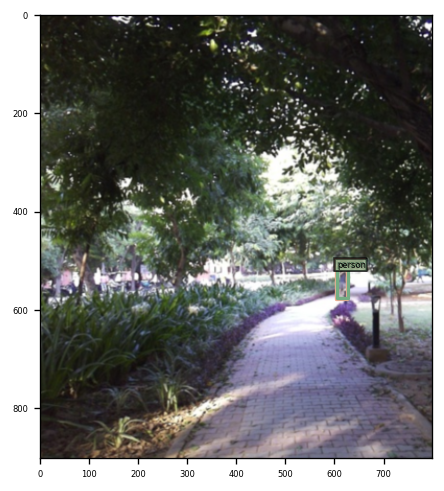

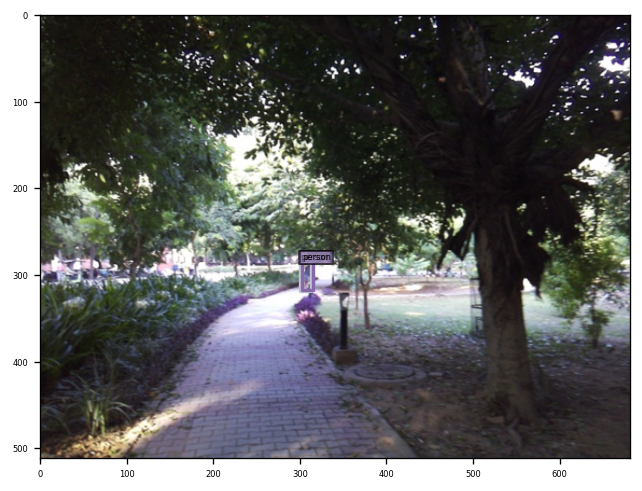

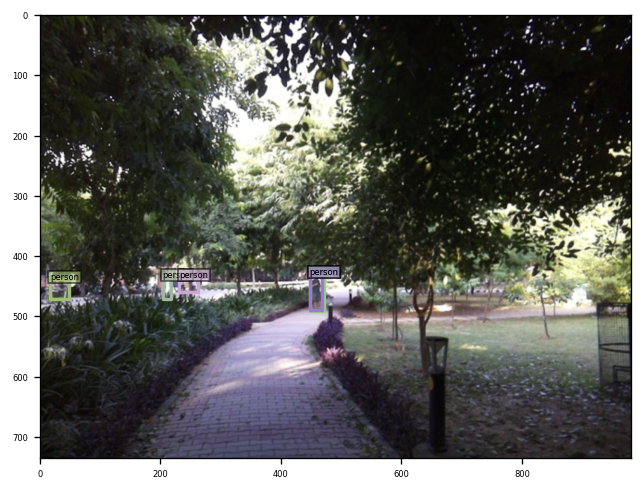

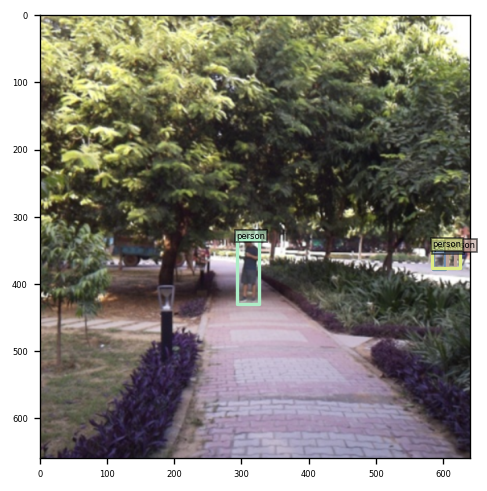

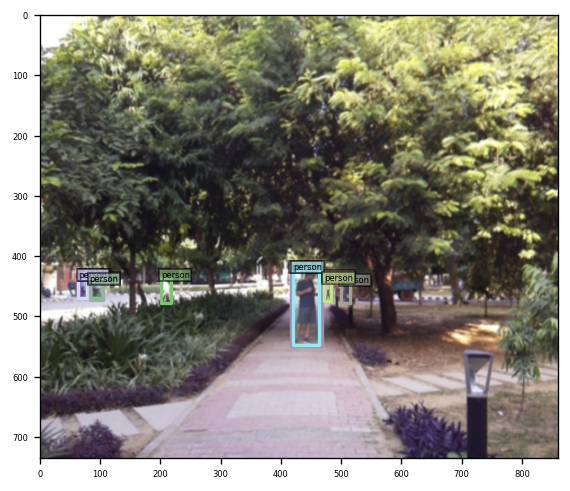

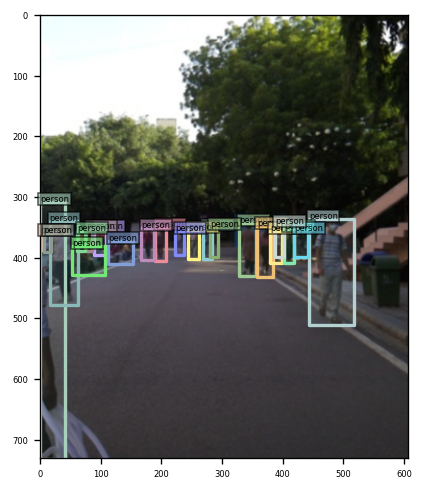

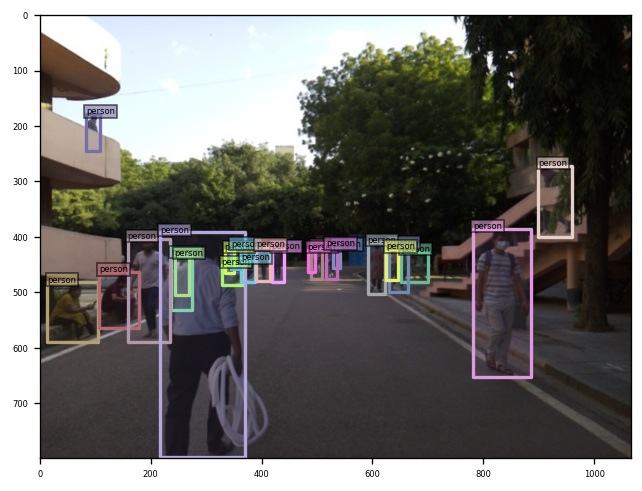

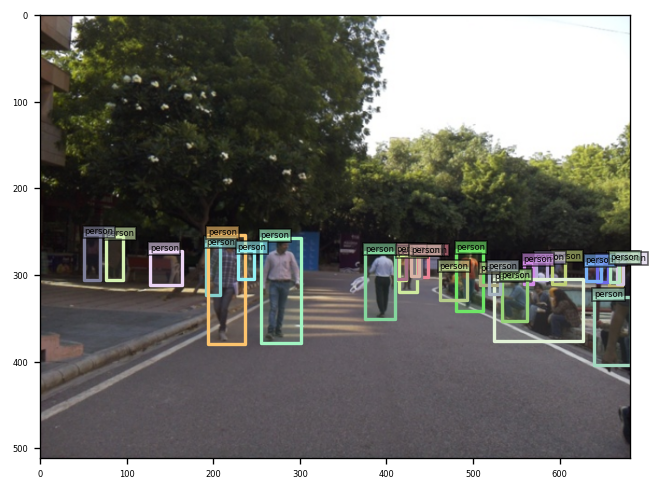

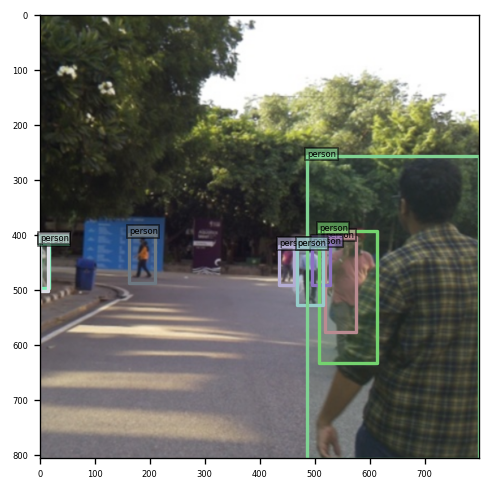

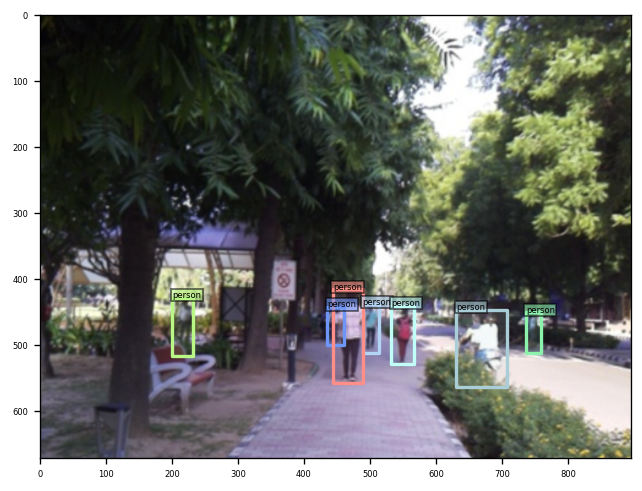

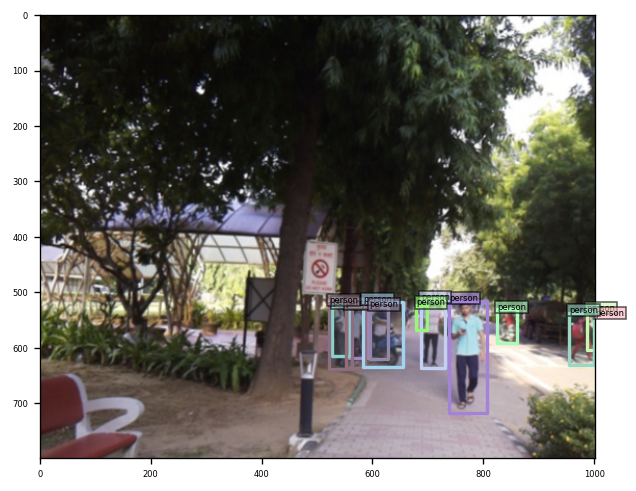

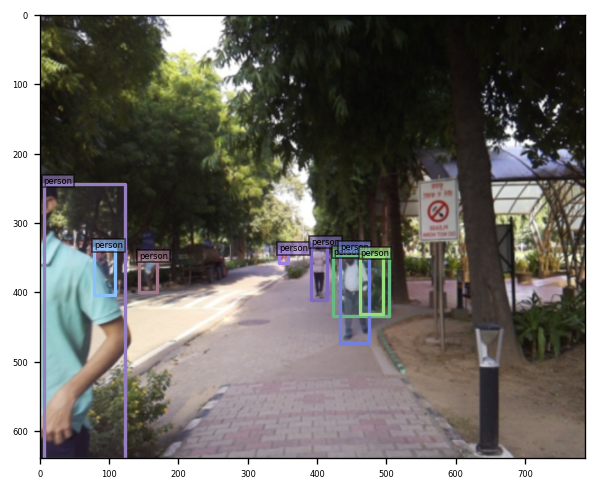

In [11]:
i=0
for idx, (image, targets) in enumerate(dataset_train):
    # build gt_dict for vis
    box_label = [id2name[int(item)] for item in targets['labels']]
    gt_dict = {
        'boxes': targets['boxes'],
        'image_id': targets['image_id'],
        'size': targets['size'],
        'box_label': box_label,
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, gt_dict, savedir=None)

    if i>10:
      break
    i+=1

In [ ]:
coco_dir = "/content/drive/MyDrive/IITDVision/datasetv2/images"

In [15]:
!bash scripts/DINO_train.sh /content/drive/MyDrive/IITDVision/datasetv2/images --pretrain_model_path model_checkpoint_path --finetune_ignore label_enc.weight class_embed

Not using distributed mode
Loading config file from config/DINO/DINO_4scale.py
[09/23 18:58:24.554]: git:
  sha: d84a491d41898b3befd8294d1cf2614661fc0953, status: has uncommited changes, branch: main

[09/23 18:58:24.554]: Command: main.py --output_dir logs/DINO/R50-MS4 -c config/DINO/DINO_4scale.py --coco_path /content/drive/MyDrive/IITDVision/datasetv2/images --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[09/23 18:58:24.554]: Full config saved to logs/DINO/R50-MS4/config_args_all.json
[09/23 18:58:24.555]: world size: 1
[09/23 18:58:24.555]: rank: 0
[09/23 18:58:24.555]: local_rank: 0
[09/23 18:58:24.555]: args: Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file='coco', coco_path='/content/drive/MyDrive/IITDVision/datasetv2/images', coco_panoptic_path=None, remove

In [13]:
!pip install pycocotools

  Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (427 kB)


In [16]:
import shutil
src = "/content/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth"
dst = "/content/drive/MyDrive/IITDVision/fine-tuned-checkpointv2.pth"
shutil.move(src, dst)

'/content/drive/MyDrive/IITDVision/fine-tuned-checkpointv2.pth'